# efd.ipynb

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from icecream import ic

In [9]:
def calculate_efd(contour, num_harmonics=10):
    """Calculates Elliptic Fourier Descriptors for a closed polygon."""
    # Ensure the contour is closed
    if not np.allclose(contour[0], contour[-1]):
        contour = np.vstack([contour, contour[0]])

    dxy = np.diff(contour, axis=0)
    dt = np.sqrt((dxy**2).sum(axis=1))
    t = np.concatenate([[0], np.cumsum(dt)])
    T = t[-1]

    phi = (2 * np.pi * t) / T
    
    coeffs = np.zeros((num_harmonics, 4))
    
    for n in range(1, num_harmonics + 1):
        # Calculate components for each harmonic
        term = 2 * np.pi * n / T
        
        # Integration using the trapezoidal rule for the polygon segments
        a_n = (T / (2 * (n * np.pi)**2)) * np.sum(
            (dxy[:, 0] / dt) * (np.cos(term * t[1:]) - np.cos(term * t[:-1]))
        )
        b_n = (T / (2 * (n * np.pi)**2)) * np.sum(
            (dxy[:, 0] / dt) * (np.sin(term * t[1:]) - np.sin(term * t[:-1]))
        )
        c_n = (T / (2 * (n * np.pi)**2)) * np.sum(
            (dxy[:, 1] / dt) * (np.cos(term * t[1:]) - np.cos(term * t[:-1]))
        )
        d_n = (T / (2 * (n * np.pi)**2)) * np.sum(
            (dxy[:, 1] / dt) * (np.sin(term * t[1:]) - np.sin(term * t[:-1]))
        )
        
        coeffs[n-1] = [a_n, b_n, c_n, d_n]
        
    return coeffs

In [10]:
def normalize_efd(coeffs):
    """Normalizes coefficients for size, rotation, and starting point invariance."""
    # 1. Size invariance: Scale by the semi-major axis of the first harmonic
    a1, b1, c1, d1 = coeffs[0]
    r1 = np.sqrt(a1**2 + c1**2) # Simplified magnitude for scaling
    
    # Optional: Full Kuhl-Giardina normalization involves calculating 
    # the phase shift and rotation angle from the first harmonic ellipse.
    # For general size-comparison, dividing by r1 is the most critical step.
    return coeffs / r1


In [11]:
def reconstruct_efd(coeffs, num_points=200):
    """Reconstructs a shape from its Fourier descriptors."""
    t = np.linspace(0, 2 * np.pi, num_points)
    x = np.zeros(num_points)
    y = np.zeros(num_points)
    
    for n, (a, b, c, d) in enumerate(coeffs):
        harm = n + 1
        x += a * np.cos(harm * t) + b * np.sin(harm * t)
        y += c * np.cos(harm * t) + d * np.sin(harm * t)
        
    return x, y


In [12]:
def visualize_harmonics(contour, harmonic_list=[1, 3, 10, 50]):
    """Plots original vs reconstructed shapes for various harmonics."""
    plt.figure(figsize=(15, 5))
    
    # Plot Original
    plt.subplot(1, len(harmonic_list) + 1, 1)
    plt.plot(contour[:, 0], contour[:, 1], 'k--', alpha=0.5)
    plt.title("Original Boundary")
    plt.axis('equal')
    
    for i, n in enumerate(harmonic_list):
        coeffs = calculate_efd(contour, num_harmonics=n)
        # ic(i, n, coeffs)
        # We don't use normalized coeffs for reconstruction overlay 
        # so they sit on top of the original shape
        rx, ry = reconstruct_efd(coeffs)
        
        plt.subplot(1, len(harmonic_list) + 1, i + 2)
        plt.plot(contour[:, 0], contour[:, 1], 'k--', alpha=0.2)
        plt.plot(rx, ry, 'r')
        plt.title(f"Harmonics: {n}")
        plt.axis('equal')
        
    plt.tight_layout()
    plt.show()

# # --- Example Usage ---
# # Creating a dummy "star" shape with noise to simulate a complicated boundary
# t_orig = np.linspace(0, 2*np.pi, 100)
# r = 10 + 3*np.sin(5*t_orig) + np.random.normal(0, 0.2, 100)
# x_orig = r * np.cos(t_orig)
# y_orig = r * np.sin(t_orig)
# sample_contour = np.column_stack([x_orig, y_orig])

# visualize_harmonics(sample_contour)

In [13]:
df

,image_path,object_index,class_id_x,polygon_points_str,x_min,y_min,x_max,y_max,confidence,class_id_y
0,08hs-palms-03-zglw-superJumbo.webp,1,0.0,"[486.0, 679.0],[486.0, 684.0],[485.0, 685.0],[...",354.5,683.500,593.5,2068.0,0.928711,0.0
1,08hs-palms-03-zglw-superJumbo.webp,0,0.0,"[1035.0, 1274.0],[1035.0, 1276.0],[1034.0, 127...",701.0,1273.000,1103.0,2066.0,0.920898,0.0
2,20251129_152106.jpg,16,0.0,"[1154.0, 233.0],[1153.0, 234.0],[1151.0, 234.0...",939.5,232.875,1329.0,997.5,0.842285,0.0
3,20251129_152106.jpg,5,0.0,"[1681.0, 715.0],[1680.0, 716.0],[1680.0, 717.0...",1592.0,715.500,1778.0,905.5,0.771484,0.0


08hs-palms-03-zglw-superJumbo.webp 1 0.929


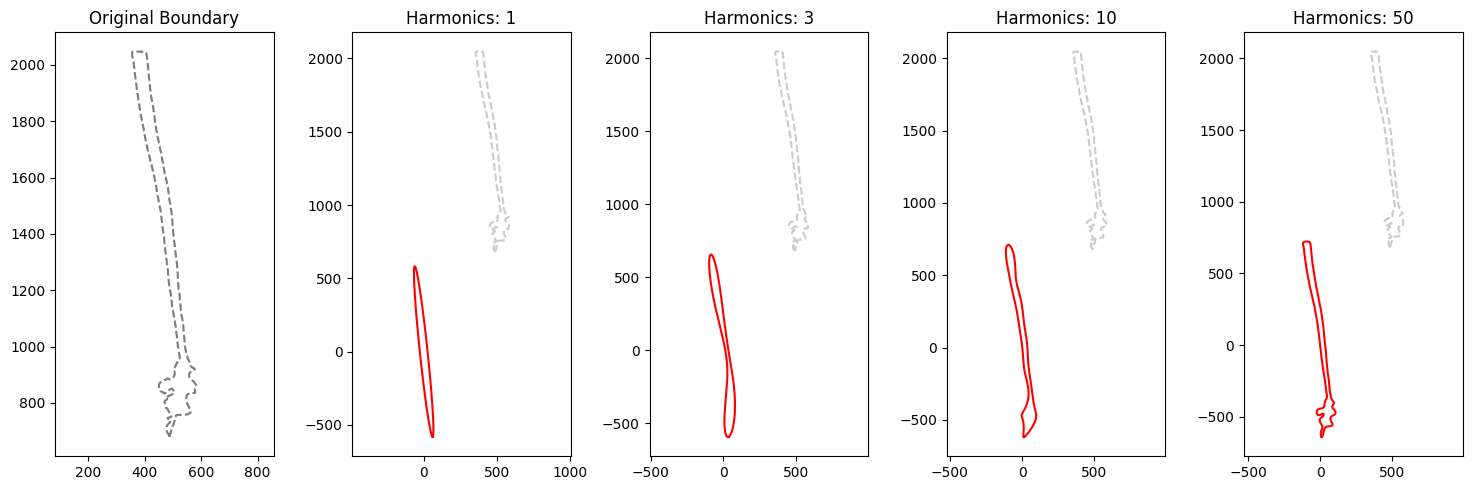

08hs-palms-03-zglw-superJumbo.webp 0 0.921


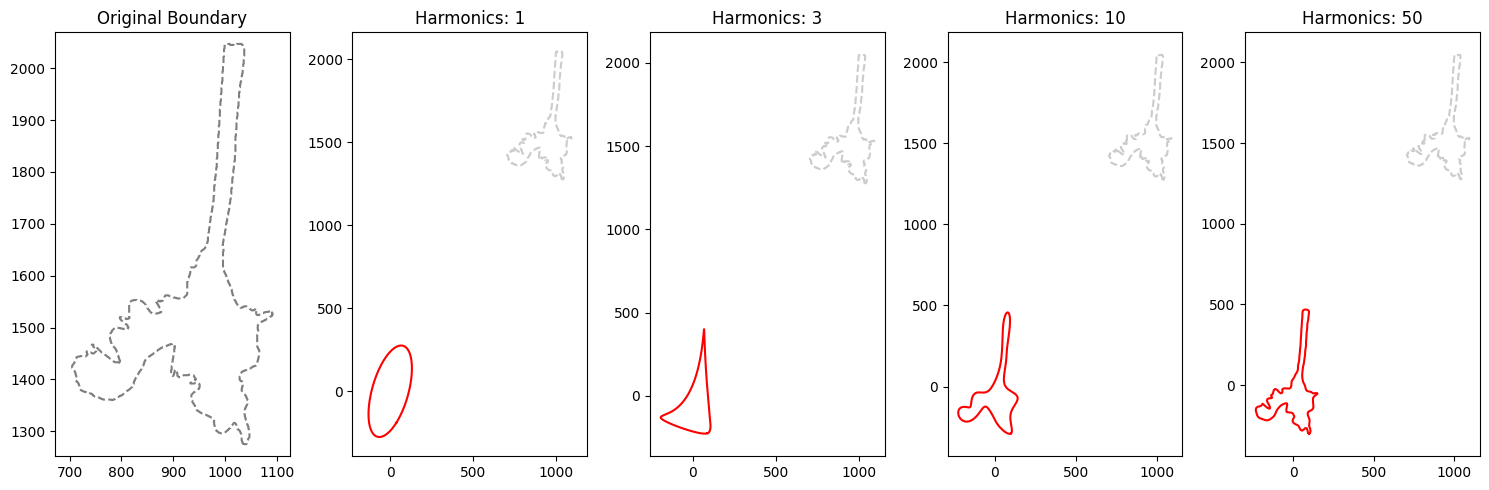

20251129_152106.jpg 16 0.842


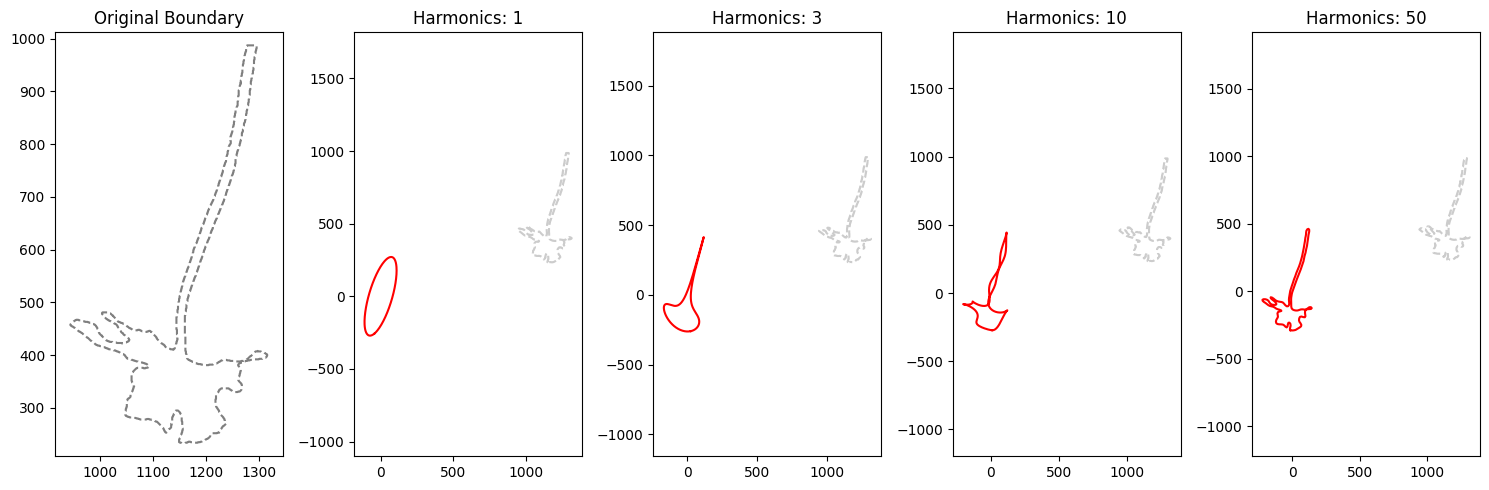

20251129_152106.jpg 5 0.771


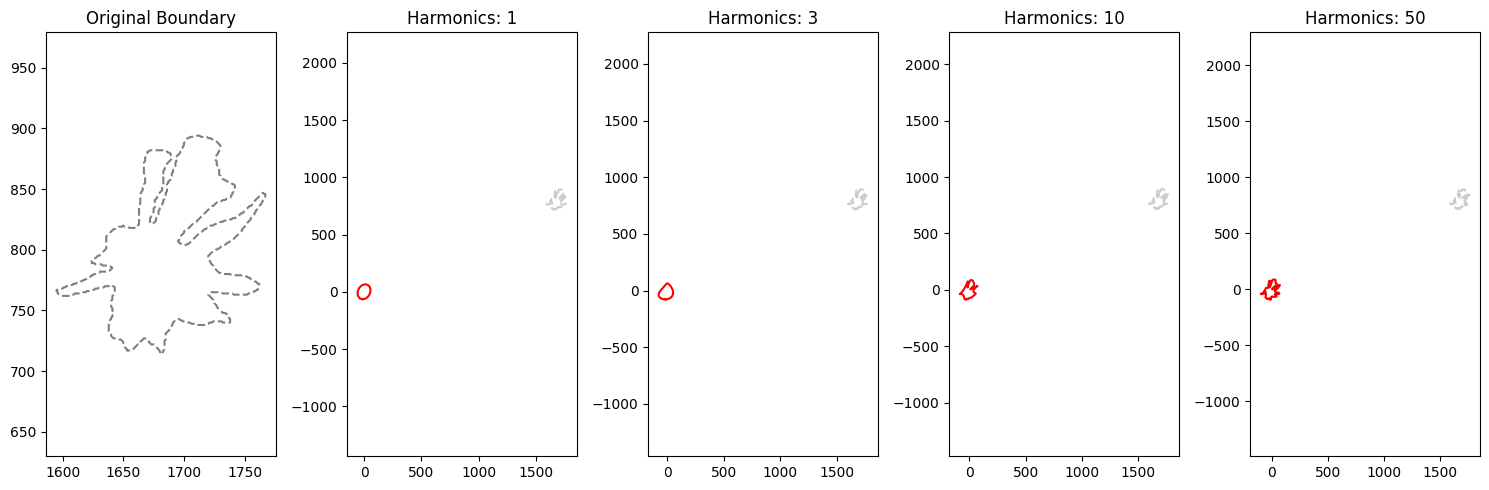

In [21]:
# Set variables for this run
database_path = 'sam3_detections.sqlite3'
sql = '''
SELECT * 
FROM detections 
ORDER BY image_path, confidence DESC, object_index 
LIMIT 4;
'''

# Read detections from the database
conn = sqlite3.connect(database_path)
df = pd.read_sql_query(sql, conn)
conn.close()

for i, r in df.iterrows():
    polygon_points_str = r['polygon_points_str']
    polygon_points = np.array(eval(polygon_points_str), np.int32)          
    # Reshape to (n, 2) format expected by calculate_efd
    contour = polygon_points.reshape((-1, 2))
    print(f"{r['image_path']} {r['object_index']} {r['confidence']:.3f}")
    visualize_harmonics(contour)
    
 